### Exploratory analysis

In [1]:
import altair as alt
import numpy as np
import pandas as pd
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import altair as alt
import pandas as pd

In [2]:
import pickle
file = open("moties_processed_df.pickle","rb")
df = pickle.load(file)
print(len(df))

column_list = df.columns.values
indiener_column = [c for c in column_list if 'Indiener' in c]
medeindiener_column = [c for c in column_list if 'Medeindiener' in c]
stem_column = [c for c in column_list if 'Stem_' in c]
aantal_stemmen_column = [c for c in column_list if 'Aantal' in c]

30653


In [3]:
def get_largest_parties(year=2020,top=False):
    tmp = df[(df['Vergaderjaar']==str(year)+'-'+str(year+1))]
    parties = [p for p in tmp.columns if 'Aantal_stemmen' in p][1:]
    tmp = tmp[parties].mean().sort_values(ascending=False)
    tmp = tmp[tmp.notna()]
    tmp.index = tmp.index.str[15:]
    if top: return tmp[:top].index
    else: return tmp.index
get_largest_parties(2020)

def to_vergaderjaar(year):
    return str(year) + '-' + str(year+1)

In [4]:
# can be removed once preprocessing done
df['Jaar'] = pd.to_datetime(df['Datum'], utc=True).dt.year
df = df[(df['Jaar'] > 2008) & (df['Jaar'] < 2021)]

In [46]:
data = df.groupby(['Jaar', 'BesluitSoort']).agg(Aantal=('Titel', 'count')).reset_index()
data = data.replace({0: 'Afgewezen', 1: 'Aangenomen'})
color_order = {'Afgewezen':1, 'Aangenomen':0}
data["idx"] = data["BesluitSoort"].map(color_order)

alt.Chart(data, width=400,height = 150).mark_bar().encode(
    x=alt.X('Jaar:N'),
    y='Aantal:Q',
    order="idx",
    color=alt.Color('BesluitSoort',
                   scale=alt.Scale(
            domain=['Aangenomen','Afgewezen'],
            range=['green', 'red']))
)

alt.Chart(...)

Het aantal moties stijgt, en met name het aantal aangenomen moties. In verkiezingsjaren (2010, 2012 en 2017) ligt het aantal moties lager. Tussen 2012 en 2013 werden veel moties afgewezen

In [58]:
source.head()

,Jaar,BesluitSoort,Aantal
0,2009,0,40.432161
1,2009,1,123.124014
2,2010,0,51.472376
3,2010,1,120.280844
4,2011,0,56.387500


In [66]:
data = df.groupby(['Jaar', 'BesluitSoort']).agg(Aantal=('Voor', 'mean')).reset_index()
data = data.replace({0: 'Afgewezen', 1: 'Aangenomen'})

# source = source.melt('index',var_name='Stem', value_name='Gemiddeld aantal voorstemmen')
# source['index'] += 2008
chart = alt.Chart(data,width=400,height = 150).mark_line().encode(
    x=alt.X('Jaar:N', axis=alt.Axis(title='Jaar')),
    y='Aantal:Q',
    color=alt.Color('BesluitSoort:N',
                scale=alt.Scale(
        domain=['Aangenomen','Afgewezen'],
        range=['green', 'red']))

)
chart.encoding.y.title = 'Aantal voorstemmen'
chart

alt.Chart(...)

Moties die worden aangenomen halen meestal rond de 120. Moties die het niet halen blijven meestal rond de 50 stemmen hangen. Eigenlijk zegt een gemiddelde niet zoveel en kan je beter naar de verdeling kijken, dat doen we nu met een histogram per kabinetsperiode.

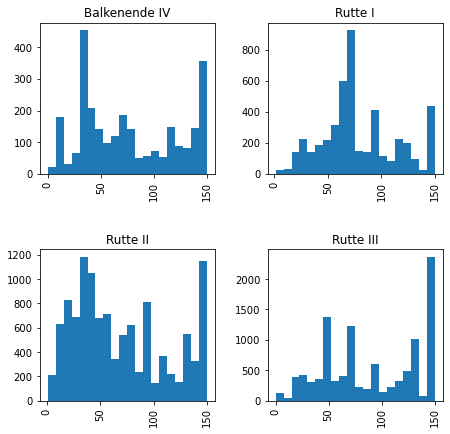

In [73]:
df['Voor'].hist(by=df['Kabinet'], bins=20, figsize=(7,7));

In bovenstaande histogrammen gaat het vooral om de verdeling van de moties. Het absolute aantal is niet echt vergelijkbaar omdat de duur van de kabinetten verschillend is. 
* Bij Balkenende IV zijn meerdere pieken te zien: protestmoties die nauwelijks stemmen krijgen, een grote piek met moties die rond de 35 stemmen blijven hangen en een piek met unanieme moties
* Bij Rutte I waren er relatief veel meer moties die het nipt wel of juist niet haalden.
* Bij Rutte II is verlijkbaar met Balkenende IV, behalve dat er meer moties het niet haalen
* Bij Rutte III is er een hele grote piek in het aantal unaniem aangenomen moties

In [181]:
year = 2010
for start_year in range(year,2021):
    source_year = df.loc[df['Vergaderjaar'] == str(start_year)+'-'+str(start_year+1)][stem_column].dropna(axis=1, how='all').T
    X_year = SimpleImputer(strategy='constant', fill_value=0).fit_transform(source_year)
    pca = PCA(n_components=1)
    pca = pca.fit(X_year)
    print('PCA results for',start_year,len(source_year))
    print(pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())  
res_year = pca.transform(X_year)
source = pd.DataFrame(res_year)
source['partij'] = source_year.T.columns.str[5:]
source = source.rename(index=str, columns={0: "x"}).sort_values('x',ascending=False)
order = source['partij']
alt.Chart(source,width=400,height = 150).mark_bar().encode(
    x=alt.X('partij:N',sort=alt.EncodingSortField(field="x", op="count", order='ascending')),
    y='x:Q'
)

PCA results for 2010 10
[0.52257064] 0.5225706363226313
PCA results for 2011 16
[0.57980882] 0.5798088214394246
PCA results for 2012 20
[0.57158395] 0.571583951315507
PCA results for 2013 21
[0.43755498] 0.4375549819214608
PCA results for 2014 19
[0.36489661] 0.3648966070384802
PCA results for 2015 17
[0.36073956] 0.36073955636755706
PCA results for 2016 19
[0.28507149] 0.28507148789747944
PCA results for 2017 13
[0.42764311] 0.427643108700503
PCA results for 2018 16
[0.45955781] 0.459557809341119
PCA results for 2019 17
[0.32158957] 0.3215895698683885
PCA results for 2020 16
[0.32481123] 0.3248112303642059


alt.Chart(...)

In [155]:
df.groupby('Vergaderjaar').agg(Mean=('BesluitSoort', 'mean'), Count=('BesluitSoort', 'count')).reset_index()

,Vergaderjaar,Mean,Count
0,2008-2009,0.411765,2057
1,2009-2010,0.460643,1461
2,2010-2011,0.409520,2332
3,2011-2012,0.396381,2321
4,2012-2013,0.329952,2070
5,2013-2014,0.377864,2051
6,2014-2015,0.384367,2482
7,2015-2016,0.442595,2883
8,2016-2017,0.466805,1928
9,2017-2018,0.432350,2609


In [502]:
# #Optional: run analysis on subset of dataset
# search = 'dieren|natuur|natura|CO2|milieuklimaat|biodiversiteit'
# print(df['Text'].str.contains(search).sum())
# df = df.loc[df['Text'].str.contains(search)]
df = (df.loc[df['Topic'].isin([23,27,21,20,8])])

### Welke partijen vertonen gelijkwaardig stemgedrag?

In [15]:
year = 2010
for start_year in range(year,2021):
    source_year = df.loc[df['Vergaderjaar'] == str(start_year)+'-'+str(start_year+1)][stem_column].dropna(axis=1, how='all').T
    X_year = SimpleImputer(strategy='constant', fill_value=0).fit_transform(source_year)
    pca = PCA(n_components=2)
    pca = pca.fit(X_year)
    print('PCA results for',start_year,'number of parties',len(source_year))
    print('explained variance two first factors', pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())  
res_year = pca.transform(X_year)
source = pd.DataFrame(res_year)
source['label'] = source_year.T.columns.str[5:]
source = source.rename(index=str, columns={0: "x", 1: "y"})                      

size= 1600
points = alt.Chart(source,width= size * pca.explained_variance_ratio_[0],height = size * pca.explained_variance_ratio_[1]).mark_point().encode(
    x=alt.X('x:Q', axis=alt.Axis(title='Eerste factor')),
    y=alt.Y('y:Q', axis=alt.Axis(title='Tweede factor')),
    tooltip=['label']
)
text = points.mark_text(
    align='left',
    baseline='middle',
    dx=np.random.uniform(0,10),
    dy=np.random.uniform(0,10),
    opacity=0.5
).encode(
    text='label'
).properties(
    title='Welke partijen lijken op elkaar'
)
points + text

PCA results for 2010 number of parties 10
explained variance two first factors [0.52257064 0.12512383] 0.6476944645407342
PCA results for 2011 number of parties 16
explained variance two first factors [0.57980882 0.12544197] 0.7052507964357742
PCA results for 2012 number of parties 20
explained variance two first factors [0.57158395 0.11293362] 0.684517575689095
PCA results for 2013 number of parties 21
explained variance two first factors [0.43755498 0.11308672] 0.5506416979390831
PCA results for 2014 number of parties 19
explained variance two first factors [0.36489661 0.11695613] 0.48185274046776666
PCA results for 2015 number of parties 17
explained variance two first factors [0.36073956 0.12529731] 0.4860368641227595
PCA results for 2016 number of parties 19
explained variance two first factors [0.28507149 0.17131722] 0.4563887079349255
PCA results for 2017 number of parties 13
explained variance two first factors [0.42764311 0.20578227] 0.633425376068026
PCA results for 2018 numb

alt.LayerChart(...)

Er zijn 3 clusters te onderscheiden: de oppositie linksonder, de regeringspartijen rechtsonder en dan nog PVV en FvD bovenaan. De horizontale as is groter omdat deze meer van het stemgedrag verklaart. Uiteindelijk kan je met deze twee factoren al ~60% van het stemgedrag verklaren.

In [13]:
min(df['Datum']).year

2008

In [14]:
year = 2018
for start_year in range(year,2021):
    source_year = df.loc[df['Vergaderjaar'] == str(start_year)+'-'+str(start_year+1)][stem_column].dropna(axis=1, how='all').T
    X_year = SimpleImputer(strategy='constant', fill_value=0).fit_transform(source_year)
    pca = PCA(n_components=1)
    pca = pca.fit(X_year)
    print('PCA results for',start_year,len(source_year))
    print(pca.explained_variance_ratio_,pca.explained_variance_ratio_.sum())  
res_year = pca.transform(X_year)
source = pd.DataFrame(res_year)
source['partij'] = source_year.T.columns.str[5:]
source = source.rename(index=str, columns={0: "x"}).sort_values('x',ascending=False)
order = source['partij']
alt.Chart(source,width=400,height = 150).mark_bar().encode(
    x=alt.X('partij:N',sort=alt.EncodingSortField(field="x", op="count", order='ascending')),
    y='x:Q'
)

PCA results for 2018 16
[0.45955781] 0.4595578093411187
PCA results for 2019 17
[0.32158957] 0.3215895698683861
PCA results for 2020 16
[0.32481123] 0.32481123036420567


alt.Chart(...)

Als we het stemgedrag visualiseren op 1 dimensie is dit het overzicht. Deze dimensie verklaart 40% van het stemgedrag. Kennelijk liggen VVD en PvdD het meest van elkaar verwijderd.

### Van Koorten en de Bie: Welke partij is de 'tegenpartij'?

In [91]:
startjaar = 2020
data = df.groupby(['Kabinet']).mean()[['Stem_'+p for p in get_largest_parties(startjaar,12)]]
data = data.reset_index()
data = data.melt('Kabinet',var_name='Stem', value_name='Stemgedrag')

alt.Chart(data,width=600).mark_line().encode(
    x='Kabinet:N',
    y=alt.Y('Stemgedrag:Q'),
    color='Stem:N',
)

alt.Chart(...)

VVD (oranje) stemt het meeste tegen. Waarschijnlijk omdat de meeste moties gericht zijn aan de regering en de VVD eigenlijk altijd regeert

### Welke partijen dienen het meeste moties in en hoe succesvol zijn ze?

In [5]:
from collections import namedtuple
import datetime
Cabinet = namedtuple('Cabinet', ['name','start', 'end', 'numyears','coalition'])

cabinets_input = [
    # "Balkenende III,07 07 2006,22 02 2007,CDA VVD",
    # "Balkenende IV,22 02 2007,14 10 2010,CDA PvdA ChristenUnie",
    "Balkenende IV,18 09 2008,14 10 2010,CDA PvdA ChristenUnie",
    "Rutte I,14 10 2010,5 11 2012,VVD CDA PVV",
    "Rutte II,5 11 2012,26 10 2017,VVD PvdA",
    "Rutte III,26 10 2017,15 01 2022,CDA VVD D66 ChristenUnie"]

cabinets = {}
for c in cabinets_input:
    c = c.split(',')
    name = c[0]
    start = list(map(int, c[1].split()))
    startdate = datetime.datetime(start[2], start[1], start[0])
    end = list(map(int, c[2].split()))
    enddate = datetime.datetime(end[2], end[1], end[0])
    numyears = (enddate - startdate).days/365
    coalition = tuple(c[3].split())
    cabinets[name] = Cabinet(name, startdate, enddate, numyears, coalition)
cabinets

{'Balkenende IV': Cabinet(name='Balkenende IV', start=datetime.datetime(2008, 9, 18, 0, 0), end=datetime.datetime(2010, 10, 14, 0, 0), numyears=2.0712328767123287, coalition=('CDA', 'PvdA', 'ChristenUnie')),
 'Rutte I': Cabinet(name='Rutte I', start=datetime.datetime(2010, 10, 14, 0, 0), end=datetime.datetime(2012, 11, 5, 0, 0), numyears=2.063013698630137, coalition=('VVD', 'CDA', 'PVV')),
 'Rutte II': Cabinet(name='Rutte II', start=datetime.datetime(2012, 11, 5, 0, 0), end=datetime.datetime(2017, 10, 26, 0, 0), numyears=4.975342465753425, coalition=('VVD', 'PvdA')),
 'Rutte III': Cabinet(name='Rutte III', start=datetime.datetime(2017, 10, 26, 0, 0), end=datetime.datetime(2022, 1, 15, 0, 0), numyears=4.2246575342465755, coalition=('CDA', 'VVD', 'D66', 'ChristenUnie'))}

In [6]:
def get_summary_stats(df):
    df = df.dropna(axis='columns',how='all')
    indiener_column = [c for c in df.columns if 'Indiener' in c]
    indiener = {p:p[9:] for p in indiener_column}
    df = df.rename(indiener,axis=1)
    largest_parties = get_largest_parties(2020,12)
    indiener_column = [i for i in indiener.values() if i in largest_parties]
    aantal_stemmen_column = [c for c in df.columns if 'Aantal_stemmen' in c]
      
    success_rate = np.multiply(df[indiener_column],df['BesluitSoort'][:, np.newaxis]).mean(axis=0).sort_index()
    success_rate = success_rate[success_rate.notna()]
    aantal_moties = df[indiener_column].sum().sort_index()
    aantal_moties = aantal_moties[aantal_moties.notna()]
    aantal_succesvolle_moties = np.multiply(success_rate,aantal_moties)
    aantal_succesvolle_moties = aantal_succesvolle_moties[aantal_succesvolle_moties.notna()]
    aantal_niet_succesvolle_moties = np.multiply((1-success_rate),aantal_moties)
    aantal_niet_succesvolle_moties = aantal_niet_succesvolle_moties[aantal_niet_succesvolle_moties.notna()]
    aantal_zetels = df[aantal_stemmen_column].mean()
    aantal_zetels = aantal_zetels[['Aantal_stemmen_'+p for p in aantal_moties.index]]
    aantal_zetels.index = aantal_moties.index
    aantal_zetels = aantal_zetels[aantal_zetels.notna()]
    aantal_zetels.index = aantal_moties.index
    aantal_moties_zetel = np.divide(aantal_moties,aantal_zetels)
    aantal_succesvolle_moties_zetel = np.divide(aantal_succesvolle_moties,aantal_zetels)
    aantal_niet_succesvolle_moties_zetel = np.divide((aantal_moties-aantal_succesvolle_moties),aantal_zetels)
    return success_rate,aantal_moties,aantal_succesvolle_moties,aantal_niet_succesvolle_moties, aantal_zetels, aantal_moties_zetel,aantal_succesvolle_moties_zetel,aantal_niet_succesvolle_moties_zetel

party_perf = pd.DataFrame({})
res_columns = ['success_rate','aantal_moties','aantal_succesvolle_moties','aantal_niet_succesvolle_moties', 'aantal_zetels', 'aantal_moties_zetel','aantal_succesvolle_moties_zetel','aantal_niet_succesvolle_moties_zetel']
for k in df['Kabinet'].unique():
    result = get_summary_stats(df.loc[df['Kabinet'] == k])
    for i,res in enumerate(result):
        df_temp = pd.DataFrame(res).reset_index()
        df_temp['stat']=res_columns[i]
        df_temp['kabinet']= k
        party_perf = party_perf.append(df_temp, ignore_index = True)
# for start_year in range(year,2020):
#     result = get_summary_stats(start_year,df.loc[df['Vergaderjaar'] == str(start_year)+'-'+str(start_year+1)])
#     for i,res in enumerate(result):
#         df_temp = pd.DataFrame(res).reset_index()
#         df_temp['stat']=res_columns[i]
#         df_temp['year']=str(start_year)+'-'+str(start_year+1)
#         party_perf = party_perf.append(df_temp, ignore_index = True)
party_perf = party_perf.rename({'index':'partij',0:'value'},axis=1)

In [7]:
# normalize metrics starting with 'aantal' to account for length of cabinet period
mask = party_perf['stat'].str.contains('aantal')
valid = party_perf[mask]
party_perf.loc[mask, 'value'] = valid['value'] / valid['kabinet'].map(lambda x: cabinets[x].numyears)

In [39]:
# Step 1: create the line
metric_of_interest = 'aantal_succesvolle_moties_zetel'
area = alt.Chart(party_perf).mark_area(interpolate="monotone").encode(
    x='kabinet:O',
    y='value:Q',
    color='partij:N'
).transform_filter(alt.FieldEqualPredicate(field='stat', equal=metric_of_interest))

data = party_perf[party_perf['stat'] == metric_of_interest]
parties=list(party_perf['partij'].unique())

def get_y_positions(party_perf, kabinet):
    return data.groupby(["kabinet", "partij"]).sum().loc[kabinet].iloc[::-1].cumsum()["value"]

def get_bar_width(kabinet, partij):
    query = f'kabinet == "{kabinet}" & partij == "{partij}"'
    return data.query(query)['value'].values[0]
    
xpos = ['Rutte III' if i%3==2 
                else 'Rutte II' if i%3==1
                else 'Rutte I' 
                for i, p in enumerate(parties)]

ys = {c: get_y_positions(party_perf, c) for c in cabinets}
ypos = [ys[xpos[i]].loc[p] - 0.5* get_bar_width(xpos[i],p) for i, p in enumerate(parties)]
test = [get_bar_width(xpos[i],p) for i, p in enumerate(parties)]
demotext = pd.DataFrame({'kabinet': xpos, 'value': ypos, 'partij': parties, 'test':test})
demotext



t = (alt.Chart(demotext).mark_text()
        .encode(
    x='kabinet:O',
    y='value:Q',
    text='partij:N'
))

# line+t
chart = alt.layer(area, t, width=600)
chart

alt.LayerChart(...)

Interessant! Bij veel partijen levert een zetel ongeveer 17 succesvolle moties op. Uitzonderingen zijn FvD en PvVV, maar ook Denk, PvdD, VVD en SP zijn minder productief. Opvallend dat de VVD eigenlijk al jaren lang weinig succesvolle moties indient, terwijl andere regeringspartijen dit wel doen.

In [271]:
party_perf = party_perf.loc[party_perf['partij'].isin(get_largest_parties(2020))]
alt.Chart(party_perf).mark_bar().encode(
    column='kabinet',
    x='value:Q',
    y='partij',
    color='stat'
).properties(width=60).transform_filter(alt.FieldOneOfPredicate(field='stat', oneOf=['aantal_succesvolle_moties','aantal_niet_succesvolle_moties']))

alt.Chart(...)

Over deze visualisatie ben ik erg tevreden. Het geeft in een oogopslag weer hoe succesvol partijen zijn geweest gedurende de jaren. Je ziet bijvoorbeeld de PVV, PvdD en SP als partijen met veel moties, maar weinig succesvolle. Hoewel de sommige partijen hiervan goede ideeen hebben, zijn ze in elk geval niet succesvol in ze door te voeren.

Bij de regeringspartijen is het opvallend hoe succesvol hun moties zijn. Waarschijnlijk omdat ze samen een meerderheid hebben en dus zo hun moties geaccepteerd krijgen.

In [278]:
alt.Chart(party_perf).mark_bar().encode(
    column='kabinet',
    x='value:Q',
    y='partij',
    color='stat'
).properties(width=60).transform_filter(alt.FieldOneOfPredicate(field='stat', oneOf=['aantal_succesvolle_moties_zetel','aantal_niet_succesvolle_moties_zetel']))

alt.Chart(...)

Wederom valt hier het lage aantal moties op bij VVD per zetel. Het is natuurlijk ook de partij met het hoogste aantal zetels, maar toch. Ook is de 'output' per zetel is vrij stabiel bij de meeste partijen, hoewel een partij die in de regering gaat meteen een stuk minder moties indient (bijvoorbeeld de PvdA)

### Wie werken samen?

In [123]:
year = 2008
medeindiener_perc = pd.DataFrame({})
for start_year in range(year,2021):
    moties_in_year = df.loc[(df['Vergaderjaar'] == str(start_year)+'-'+str(start_year+1))]
    moties_in_year = moties_in_year.dropna(axis=1, how='all')
    indieners = [c for c in moties_in_year.columns if 'Indiener' in c]
    medeindieners = [c for c in moties_in_year.columns if 'Medeindiener' in c]
    stem = ['Stem_'+c[13:] for c in medeindieners]
    assert len(stem) == len(medeindieners)
    for p in indieners:
        partij_moties =  moties_in_year.loc[(moties_in_year[p]==1)]
        res = (partij_moties[medeindieners].sum() / partij_moties[stem].notna().sum().values)
        res = pd.DataFrame({'support':res.index.str[13:],'percentage':res.values, 'mede':partij_moties[medeindieners].sum(), 'stem':partij_moties[stem].notna().sum().values})
        res['partij']= p[9:]
        res['year']=str(start_year)+'-'+str(start_year+1)
        # how often did the party cosign & vote / how often did the party vote
        res2 =partij_moties[medeindieners].values * partij_moties[stem].values
        res2 = pd.DataFrame({'support': [s[5:] for s in stem], 'percentage':np.nansum(res2, axis=0)/partij_moties[stem].notna().sum().values})
        res2['partij']= p[9:]
        res2['year']=str(start_year)+'-'+str(start_year+1)
        medeindiener_perc = medeindiener_perc.append(res2)      

In [110]:
[s[5:] for s in stem]

['50PLUS',
 'CDA',
 'ChristenUnie',
 'D66',
 'DENK',
 'FvD',
 'GroenLinks',
 'Krol',
 'PVV',
 'PvdA',
 'PvdD',
 'SGP',
 'SP',
 'VVD',
 'Van Haga',
 'Van Kooten-Arissen']

In [94]:
# There are some cases where a party is submitting a moties but not voting on it, see below example
# https://www.tweedekamer.nl/kamerstukken/detail?id=2020Z22006&did=2020D46879

In [124]:
medeindiener_perc = medeindiener_perc[medeindiener_perc['support'].isin(order)]
medeindiener_perc = medeindiener_perc[medeindiener_perc['partij'].isin(order)]

alt.Chart(medeindiener_perc,height=250,width=250).mark_rect().encode(
    #column='year:N',
    x=alt.X('support:N', sort=list(order)),
    y=alt.Y('partij:N', sort=list(order)),    
    color=alt.Color('percentage', scale=alt.Scale(scheme='greens'))
).transform_filter(alt.FieldOneOfPredicate(field='year', oneOf=['2020-2021']))##.properties(width=200)

alt.Chart(...)

In [115]:
medeindiener_perc[medeindiener_perc['partij']=='Van Haga']
# here goes something wrong: FVD has cosigned van haga, but then did not vote. This makes a percentage >100 possible :S

,support,percentage,partij,year
0,50PLUS,0.000000,Van Haga,2020-2021
1,CDA,0.000000,Van Haga,2020-2021
2,ChristenUnie,0.000000,Van Haga,2020-2021
3,D66,0.000000,Van Haga,2020-2021
4,DENK,0.000000,Van Haga,2020-2021
5,FvD,1.000000,Van Haga,2020-2021
6,GroenLinks,0.000000,Van Haga,2020-2021
7,Krol,0.000000,Van Haga,2020-2021
8,PVV,0.038462,Van Haga,2020-2021
9,PvdA,0.000000,Van Haga,2020-2021


Duidelijk is hier te zien dat de regeringspartijen en de oppositiepartijen vaak samen moties indienen

In [122]:
alt.Chart(medeindiener_perc,height=150,width=150).mark_rect().encode(
    column='partij:N',
    x=alt.X('year:N'),
    y=alt.Y('support:N', sort=list(order)),    
    color=alt.Color('percentage', scale=alt.Scale(scheme='greens')))

alt.Chart(...)

Hier zijn weer heel mooi de effecten te zien van in de regering zitten. Het tijdelijke pact tussen PvdA en VVD, en de huidige steun van de regeringspartijen aan elkaar. Andere opvallende zaken:
- SGP diende vroeger vaak met CDA en CU moties in, dit is de afgelopen jaren een stuk minder geworden
- Groenlinks en PvdA zijn vaak medeindiener bij elkaars moties
- Denk, FvD en PVV hebben vrijwel nooit medeindieners
- Bij moties van de ChristenUnie zijn de afgelopen jaren de regeringspartijen vaak medeindiener

In [128]:
year = 2010
stem_perc = pd.DataFrame({})
for start_year in range(year,2021):
    moties_in_year = df.loc[(df['Vergaderjaar'] == str(start_year)+'-'+str(start_year+1))]
    moties_in_year = moties_in_year.dropna(axis=1, how='all')
    indieners = [c for c in moties_in_year.columns if 'Indiener' in c]
    stem = [c for c in moties_in_year.columns if 'Stem' in c][1:]
    
    #print(stem)
    for p in indieners:
        #print(p,p[9:])
        partij_moties =  moties_in_year.loc[(moties_in_year[p]==1)] 
        
        partij_moties = partij_moties.replace(-1,0)
        #print(partij_moties['Stem_FvD'])
        #print('bla',partij_moties[stem].sum(),len(partij_moties))
        res = (partij_moties[stem].sum()/partij_moties[stem].notna().sum())
        
        #print('res',res)
        res = pd.DataFrame({'support':res.index.str[5:],'percentage':res.values})
        res['partij']= p[9:]
        res['year']=str(start_year)+'-'+str(start_year+1)
        stem_perc = stem_perc.append(res)

In [129]:
stem_perc = stem_perc[stem_perc['support'].isin(order)]
stem_perc = stem_perc[stem_perc['partij'].isin(order)]

alt.Chart(stem_perc,height=250,width=250).mark_rect().encode(
    column = 'year',
    x=alt.X('support:N', sort=list(order)),
    y=alt.Y('partij:N', sort=list(order)),
    color=alt.Color('percentage', scale=alt.Scale(scheme='redyellowgreen'))
).transform_filter(alt.FieldOneOfPredicate(field='year', oneOf=['2020-2021']))#.properties(width=200)

alt.Chart(...)

In [135]:
test = stem_perc[stem_perc['support']==stem_perc['partij']]

Au! Dat doet pijn bij FvD! Bijna alle partijen stemmen tegen hun moties, behalve PVV en 50Plus.
Van de oppositiepartijen krijgen alleen SGP, 50Plus, PvdA en Groenlinks regelmatig steun van de regeringspartijen. De andere partijen kunnen dit over het algemeen vergeten.
PvdD krijgt nog wat hulp van Groenlinks en de SP.

In [136]:
stem_perc = stem_perc[stem_perc['support'].isin(order)]
stem_perc = stem_perc[stem_perc['partij'].isin(order)]

alt.Chart(stem_perc,height=150,width=150).mark_rect().encode(
    column = 'partij',
    x=alt.X('year:N', sort=list(order)),
    y=alt.Y('support:N'),
    color=alt.Color('percentage', scale=alt.Scale(scheme='redyellowgreen'))
)#.properties(width=200)

alt.Chart(...)

### Voorspel stemuitslag

In [519]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
start_year = 2008

scores = []
for s in range(start_year,2019):
    X = df.loc[df['Vergaderjaar'] == str(s)+'-'+str(s+1)][indiener_column+medeindiener_column].dropna(how='all',axis=1)
    X_imp = SimpleImputer(strategy='constant', fill_value=0).fit_transform(X)
    y = df.loc[df['Vergaderjaar'] == str(s)+'-'+str(s+1)]['BesluitSoort']
    X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.5, shuffle=False)


    clf = LogisticRegression(random_state=0, solver='lbfgs',
                             multi_class='ovr').fit(X_train, y_train)

    print('score',clf.score(X_test, y_test),'baseline',y.value_counts()[0]/len(y))
    scores.append(clf.score(X_test, y_test))
    print (confusion_matrix(y_test, clf.predict(X_test), sample_weight=None))
print (np.mean(scores))

score 0.8571428571428571 baseline 0.6566037735849056
[[77  7]
 [12 37]]
score 0.7045454545454546 baseline 0.5113636363636364
[[34 14]
 [12 28]]
score 0.7692307692307693 baseline 0.5745192307692307
[[113  13]
 [ 35  47]]
score 0.6814159292035398 baseline 0.6208425720620843
[[116  19]
 [ 53  38]]
score 0.7789473684210526 baseline 0.6236842105263158
[[98  8]
 [34 50]]
score 0.7681159420289855 baseline 0.6159420289855072
[[110  31]
 [ 17  49]]
score 0.8129496402877698 baseline 0.6378378378378379
[[160  18]
 [ 34  66]]
score 0.7348993288590604 baseline 0.5008403361344538
[[115  35]
 [ 44 104]]
score 0.6794258373205742 baseline 0.5179856115107914
[[91 20]
 [47 51]]
score 0.8350877192982457 baseline 0.5508771929824562
[[139   5]
 [ 42  99]]
score 0.8401162790697675 baseline 0.42877906976744184
[[124  16]
 [ 39 165]]
0.7692615568552796


In [520]:
score 0.8626692456479691 baseline 0.5882922109337204
[[547  41]
 [101 345]]
score 0.8215258855585831 baseline 0.5398773006134969
[[335  35]
 [ 96 268]]
score 0.7974468085106383 baseline 0.5904640272456364
[[712  15]
 [223 225]]
score 0.7258753202391118 baseline 0.6041844577284372
[[655  60]
 [261 195]]
score 0.7990384615384616 baseline 0.6697115384615384
[[655  28]
 [181 176]]
score 0.8318840579710145 baseline 0.6205896568390527
[[589  79]
 [ 95 272]]
score 0.7923015236567763 baseline 0.6165262735659848
[[702  34]
 [225 286]]
score 0.771881461061337 baseline 0.5578911095796003
[[724  98]
 [233 396]]
score 0.7051546391752578 baseline 0.534020618556701
[[461  65]
 [221 223]]
score 0.8467987804878049 baseline 0.5669081204727411
[[683  22]
 [179 428]]
score 0.8053152039555006 baseline 0.4765142150803461
[[636  93]
 [222 667]]
0.7963537625274959

SyntaxError: invalid syntax (<ipython-input-520-ef377a693042>, line 1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
start_year = 2008
predict = stem_column+['BesluitSoort']
scores = []
for s in predict:
    X = df.loc[(df['Vergaderjaar'] == '2018-2019') & (df[s].notnull())][indiener_column+medeindiener_column].dropna(how='all',axis=1)
    if len(X)!=0:
        X_imp = SimpleImputer(strategy='constant', fill_value=0).fit_transform(X)

        y = df.loc[(df['Vergaderjaar'] == '2018-2019')& (df[s].notnull())][s]
        X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.5, shuffle=False)


        clf = LogisticRegression(random_state=0, solver='lbfgs',
                                 multi_class='ovr').fit(X_train, y_train)

        print(clf.score(X_test, y_test),y.value_counts()[0]/len(y))
        scores.append(clf.score(X_test, y_test))
        print('score',clf.score(X_test, y_test),'baseline',y.value_counts()[0]/len(y))
print (np.mean(scores))

In [ ]:
df['Topic'].hist()